# Measuring Statistics about Information Sources in MIDI Files

A MIDI file can provide a cornucopia of musical information about a given piece of music, including transcription, key, lyrics, and meter.
However, the presence and quantity of each of these sources of information can vary.
Through a large-scale web scrape, we obtained 178,561 unique (i.e. having different MD5 checksums) MIDI files.
This notebook measures the availability of each possible source of information in MIDI files in this collection of MIDIs found "in the wild".

In [1]:
%load_ext autoreload
%autoreload 2

import pretty_midi
import numpy as np
import joblib
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
# plotting.py contains utility functions for making nice histogram plots
import plotting
from math import isclose

## Compute statistics

The `compute_statistics` function takes in a MIDI file and simply collects the number, and values for, different events (for example, key change values and tempo settings) in the file.
We will call this function for every entry in our 178,561 MIDI file collection and use these measurements to study the distributions of different event values and quantities of different event types.

In [2]:
def beat_accuracy(pm, eps=0.001):
    # Use notes in first instrument to measure how well beats line up with note onsets
    if (len(pm.instruments) == 0) or (len(pm.instruments[0].notes) == 0):
        return -1, -1

    note_onsets = []

    for nt in pm.instruments[0].notes:
        note_onsets.append(nt.start)

    dists = []
    onbeats = []

    for beat in pm.get_beats():
        region_start = beat - eps
        region_end = beat + eps

        # get all note onsets between region_start and region_end
        region_note_onsets = [on for on in note_onsets if on >= region_start and on <= region_end]

        dist = []
        onbeat = []

        for on in region_note_onsets:
            dist.append(abs(beat - on))
            onbeat.append(isclose(beat, on))

        if len(dist) != 0:
            dists.append(sum(dist)/len(dist))
            onbeats.append(sum(onbeat)/len(onbeat))

    if (len(dists)) != 0:
        avg_dist = sum(dists)/len(dists)
        avg_onbeat = sum(onbeats)/len(onbeats)
    else:
        avg_dist = -1
        avg_onbeat = -1

    return avg_dist, avg_onbeat

In [3]:
def compute_statistics(midi_file):
    """
    Given a path to a MIDI file, compute a dictionary of statistics about it
    
    Parameters
    ----------
    midi_file : str
        Path to a MIDI file.
    
    Returns
    -------
    statistics : dict
        Dictionary reporting the values for different events in the file.
    """
    # Some MIDI files will raise Exceptions on loading, if they are invalid.
    # We just skip those.
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        # Extract informative events from the MIDI file
        return {'n_instruments': len(pm.instruments),
                'notes': [n.pitch for i in pm.instruments for n in i.notes],
                'velocities': [n.velocity for i in pm.instruments for n in i.notes],
                'program_numbers': [i.program for i in pm.instruments if not i.is_drum],
                'key_numbers': [k.key_number for k in pm.key_signature_changes],
                'tempos': list(pm.get_tempo_changes()[1]),
                'time_signature_changes': pm.time_signature_changes,
                'end_time': pm.get_end_time(),
                'lyrics': [l.text for l in pm.lyrics],
                'beat_accuracy': beat_accuracy(pm)}
    # Silently ignore exceptions for a clean presentation (sorry Python!)
    except Exception as e:
        pass

In [83]:
# Compute statistics about every file in our collection in parallel using joblib
# We do things in parallel because there are tons so it would otherwise take too long!
statistics = joblib.Parallel(n_jobs=10, verbose=0)(
    joblib.delayed(compute_statistics)(midi_file)
    for midi_file in glob.glob(os.path.join('data', 'lmd_full', '*', '*.mid'))[:10])
# When an error occurred, None will be returned; filter those out.
statistics = [s for s in statistics if s is not None]

# Just run this if statistics.pkl in directory (after running run_statistics.py)

In [2]:
import pickle

# Load the statistics from the file
with open('statistics.pkl', 'rb') as file:
    statistics = pickle.load(file)


# Velocities and Beats

In [5]:
import collections

# find the most prevalent velocities
velocities = [v for s in statistics for v in s['velocities']]
# Count the occurrences of each velocity
velocity_counts = collections.Counter(velocities)

# Get the top 10 most frequent velocities
top_velocities = velocity_counts.most_common(10)

# Print the top 10 most frequent velocities
for velocity, count in top_velocities:
    print(f"Velocity: {velocity}, Count: {count}")

Velocity: 127, Count: 57194576
Velocity: 100, Count: 50888868
Velocity: 80, Count: 23407454
Velocity: 95, Count: 20065730
Velocity: 64, Count: 17778175
Velocity: 110, Count: 17230121
Velocity: 90, Count: 16282741
Velocity: 70, Count: 11675958
Velocity: 60, Count: 9801856
Velocity: 85, Count: 9598042


In [44]:
count_1 = 0
counter_1 = collections.Counter()
count_2 = 0
counter_2 = collections.Counter()
count_3 = 0
counter_3 = collections.Counter()
count_4 = 0
counter_4 = collections.Counter()

for i in range(len(statistics)):
    if (len(set(statistics[i]['velocities'])) == 1):
        count_1 += 1
        counter_1[statistics[i]['velocities'][0]] += 1
    elif (len(set(statistics[i]['velocities'])) == 2):
        count_2 += 1
        counter_2[tuple(set(statistics[i]['velocities']))] += 1
    elif (len(set(statistics[i]['velocities'])) == 3):
        count_3 += 1
        counter_3[tuple(set(statistics[i]['velocities']))] += 1
    elif (len(set(statistics[i]['velocities'])) == 4):
        count_4 += 1
        counter_4[tuple(set(statistics[i]['velocities']))] += 1

print(count_1, count_1/len(statistics))
print(count_2, count_2/len(statistics))
print(count_3, count_3/len(statistics))
print(count_4, count_4/len(statistics))

25028 0.14344584099910015
7068 0.04050963737340738
4440 0.02544748018363452
3589 0.020570046481771236


In [ ]:
# Find how many entries in velocities have only 127
n_max_velocity = sum([1 for v in velocities if set(v) == 127])

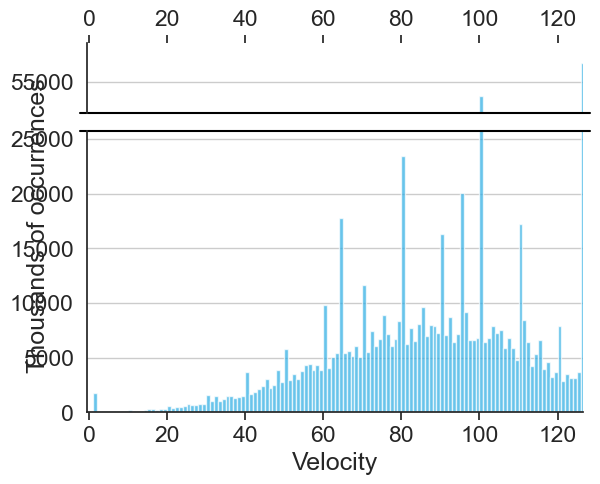

In [4]:
velocities = [v for s in statistics for v in s['velocities']]
plotting.plot_hist(velocities, range(128), 'Velocity', 'Thousands of occurrences')

In [135]:
statistics[0]['beat_accuracy'][0]

1.8946965208887046e-14

In [17]:
sum([isclose(s['beat_accuracy'][0], 0, abs_tol=1e-08) for s in statistics]) / len(statistics)

0.9102059297213959

(array([ 13648.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 160829.]),
 array([-1.    , -0.8999, -0.7998, -0.6997, -0.5996, -0.4995, -0.3994,
        -0.2993, -0.1992, -0.0991,  0.001 ]),
 <BarContainer object of 10 artists>)

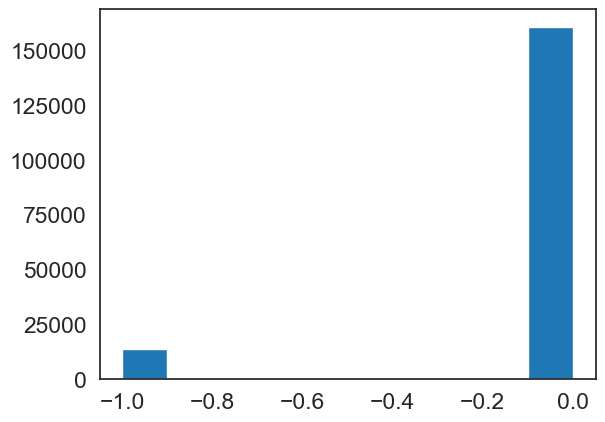

In [140]:
plt.hist([s['beat_accuracy'][0] for s in statistics])

In [19]:
sum([isclose(s['beat_accuracy'][1], 1, abs_tol=1e-08) for s in statistics]) / len(statistics)

0.9102116611358517

(array([ 13648.,      0.,      0.,      0.,      0.,    385.,    396.,
           335.,    258., 159455.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

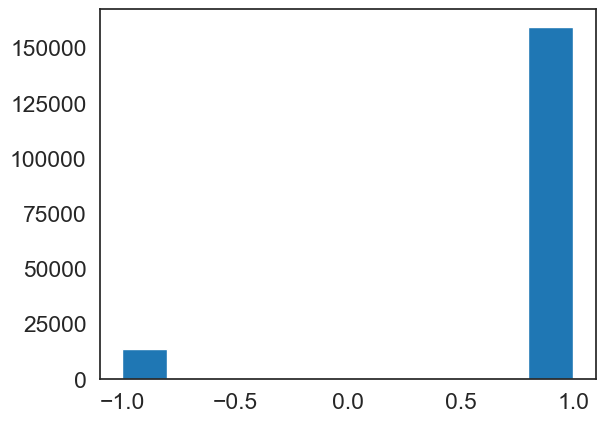

In [18]:
plt.hist([s['beat_accuracy'][1] for s in statistics])

In [138]:
plotting.plot_hist([s['beat_accuracy'][0] for s in statistics], range(1),
                   'Beat accuracy onset heuristic', 'Thousands of occurrences')

/Users/npb/miniconda3/envs/musicvae/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/npb/miniconda3/envs/musicvae/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

<Figure size 640x480 with 0 Axes>

## Length
To begin with, we can get an idea of the type of MIDI files which are available by looking at their length (i.e. time in seconds).  MIDI files are variously used for storing short melodic fragmets, drum patterns, ringtones, and full-song transcriptions; looking at the distribution of lengths of MIDI files in our collection gives a rough picture of how common each of these uses is.

/Users/npb/Desktop/lmd-statistics/plotting.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(float(t) / divisor)


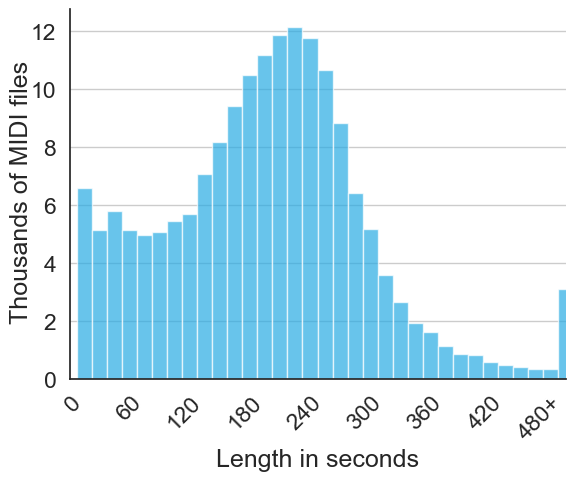

In [109]:
plotting.plot_hist([s['end_time'] for s in statistics], range(0, 500, 15),
                   'Length in seconds', 'Thousands of MIDI files')
plt.xticks(np.arange(0, len(range(0, 500, 15)), 4) + .5,
           list(range(0, 430, 60)) + ['480+'], rotation=45, ha='right');

## Instruments
In their simplest form, MIDI files contain a collection of notes played on a collection of instruments.  Under the General MIDI specification, 128 instruments are available (see `pretty_midi.INSTRUMENT_MAP` for a list) which are indexed by their "program number".  The distribution of the number of instruments in our MIDI files gives us further intuition into the MIDI files' usage; the distribution of program numbers shows us which instruments are more or less popular.  The four most common program numbers (shown as the four tallest bars in the distribution of program numbers) were 0 (“Acoustic Grand Piano”), 48 (“String Ensemble 1”), 33 (“Electric Bass (finger)”), and 25 (“Acoustic Guitar (steel)”).

In [23]:
collections.Counter([s['n_instruments'] for s in statistics])

Counter({1: 17205,
         9: 14372,
         8: 13982,
         10: 13484,
         7: 13458,
         6: 12077,
         11: 10725,
         2: 10129,
         4: 10124,
         12: 9812,
         5: 9515,
         13: 6939,
         14: 6902,
         3: 6548,
         15: 5327,
         16: 3960,
         18: 2023,
         17: 1857,
         19: 1077,
         20: 801,
         22: 733,
         21: 620,
         23: 395,
         24: 330,
         26: 303,
         25: 289,
         0: 206,
         27: 173,
         28: 155,
         30: 136,
         29: 95,
         31: 83,
         32: 61,
         36: 53,
         34: 48,
         37: 47,
         33: 40,
         35: 36,
         38: 29,
         41: 29,
         40: 28,
         49: 22,
         42: 22,
         46: 19,
         39: 18,
         44: 17,
         45: 13,
         43: 12,
         51: 10,
         50: 10,
         63: 9,
         48: 9,
         53: 8,
         60: 7,
         47: 6,
         56: 6,
      

/Users/npb/Desktop/anticipation/lmd-statistics/plotting.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(float(t) / divisor)


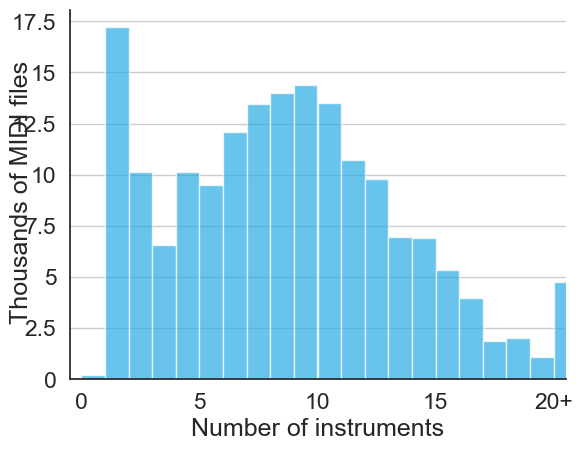

In [5]:
plotting.plot_hist([s['n_instruments'] for s in statistics], range(22),
                   'Number of instruments', 'Thousands of MIDI files')
plt.xticks(range(0, 22, 5), list(range(0, 22 - 5, 5)) + ['20+']);

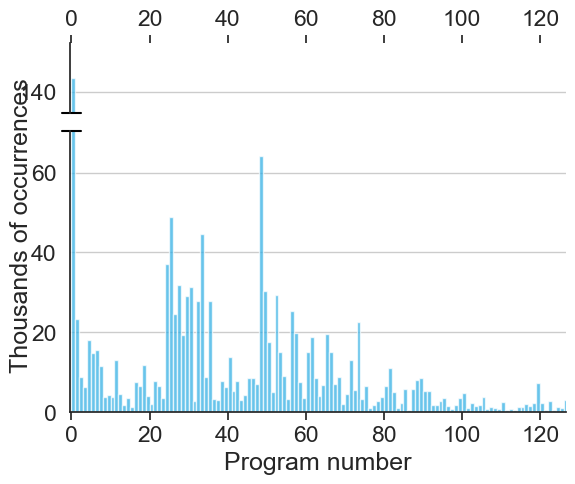

In [6]:
plotting.plot_hist([i for s in statistics for i in s['program_numbers']], range(128),
                   'Program number', 'Thousands of occurrences')

In [9]:
program_nums = [i for s in statistics for i in s['program_numbers']]

In [22]:
general_midi_instruments = {
    1: "Acoustic Grand Piano",
    2: "Bright Acoustic Piano",
    3: "Electric Grand Piano",
    4: "Honky-tonk Piano",
    5: "Electric Piano 1",
    6: "Electric Piano 2",
    7: "Harpsichord",
    8: "Clavinet",
    9: "Celesta",
    10: "Glockenspiel",
    11: "Music Box",
    12: "Vibraphone",
    13: "Marimba",
    14: "Xylophone",
    15: "Tubular Bells",
    16: "Dulcimer",
    17: "Drawbar Organ",
    18: "Percussive Organ",
    19: "Rock Organ",
    20: "Church Organ",
    21: "Reed Organ",
    22: "Accordion",
    23: "Harmonica",
    24: "Tango Accordion",
    25: "Acoustic Guitar (nylon)",
    26: "Acoustic Guitar (steel)",
    27: "Electric Guitar (jazz)",
    28: "Electric Guitar (clean)",
    29: "Electric Guitar (muted)",
    30: "Overdriven Guitar",
    31: "Distortion Guitar",
    32: "Guitar Harmonics",
    33: "Acoustic Bass",
    34: "Electric Bass (finger)",
    35: "Electric Bass (pick)",
    36: "Fretless Bass",
    37: "Slap Bass 1",
    38: "Slap Bass 2",
    39: "Synth Bass 1",
    40: "Synth Bass 2",
    41: "Violin",
    42: "Viola",
    43: "Cello",
    44: "Contrabass",
    45: "Tremolo Strings",
    46: "Pizzicato Strings",
    47: "Orchestral Harp",
    48: "Timpani",
    49: "String Ensemble 1",
    50: "String Ensemble 2",
    51: "Synth Strings 1",
    52: "Synth Strings 2",
    53: "Choir Aahs",
    54: "Voice Oohs",
    55: "Synth Voice",
    56: "Orchestra Hit",
    57: "Trumpet",
    58: "Trombone",
    59: "Tuba",
    60: "Muted Trumpet",
    61: "French Horn",
    62: "Brass Section",
    63: "Synth Brass 1",
    64: "Synth Brass 2",
    65: "Soprano Sax",
    66: "Alto Sax",
    67: "Tenor Sax",
    68: "Baritone Sax",
    69: "Oboe",
    70: "English Horn",
    71: "Bassoon",
    72: "Clarinet",
    73: "Piccolo",
    74: "Flute",
    75: "Recorder",
    76: "Pan Flute",
    77: "Blown Bottle",
    78: "Shakuhachi",
    79: "Whistle",
    80: "Ocarina",
    81: "Lead 1 (square)",
    82: "Lead 2 (sawtooth)",
    83: "Lead 3 (calliope)",
    84: "Lead 4 (chiff)",
    85: "Lead 5 (charang)",
    86: "Lead 6 (voice)",
    87: "Lead 7 (fifths)",
    88: "Lead 8 (bass + lead)",
    89: "Pad 1 (new age)",
    90: "Pad 2 (warm)",
    91: "Pad 3 (polysynth)",
    92: "Pad 4 (choir)",
    93: "Pad 5 (bowed)",
    94: "Pad 6 (metallic)",
    95: "Pad 7 (halo)",
    96: "Pad 8 (sweep)",
    97: "FX 1 (rain)",
    98: "FX 2 (soundtrack)",
    99: "FX 3 (crystal)",
    100: "FX 4 (atmosphere)",
    101: "FX 5 (brightness)",
    102: "FX 6 (goblins)",
    103: "FX 7 (echoes)",
    104: "FX 8 (sci-fi)",
    105: "Sitar",
    106: "Banjo",
    107: "Shamisen",
    108: "Koto",
    109: "Kalimba",
    110: "Bagpipe",
    111: "Fiddle",
    112: "Shanai",
    113: "Tinkle Bell",
    114: "Agogo",
    115: "Steel Drums",
    116: "Woodblock",
    117: "Taiko Drum",
    118: "Melodic Tom",
    119: "Synth Drum",
    120: "Reverse Cymbal",
    121: "Guitar Fret Noise",
    122: "Breath Noise",
    123: "Seashore",
    124: "Bird Tweet",
    125: "Telephone Ring",
    126: "Helicopter",
    127: "Applause",
    128: "Gunshot"
}

In [5]:
# Generate a co-occurence matrix of program numbers from statistics
program_cooc = np.zeros((128, 128))
for program_nums in [s['program_numbers'] for s in statistics]:
    for p1 in program_nums:
        for p2 in program_nums:
            if p1 != p2:
                program_cooc[p1, p2] += 1

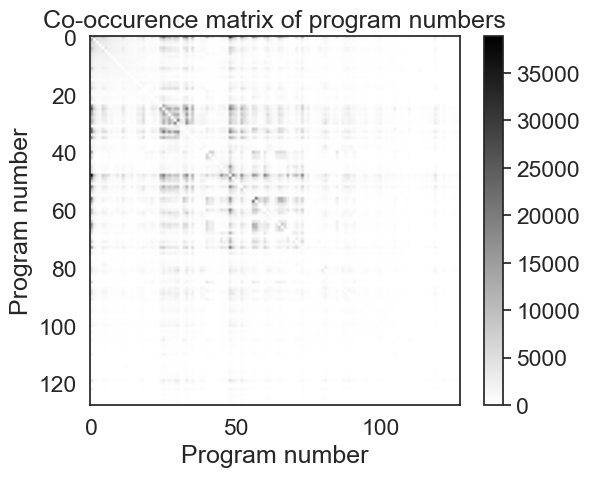

In [6]:
import matplotlib.pyplot as plt

# Visualize program_cooc
plt.imshow(program_cooc, cmap='gray_r')
plt.xlabel('Program number')
plt.ylabel('Program number')
plt.title('Co-occurence matrix of program numbers')
plt.colorbar()

In [8]:
# Dictionary of instrument categories to program numbers
reduced_instruments = {}
# Piano
reduced_instruments[0] = [0, 1, 2, 3, 4, 5, 6, 7]
# Chromatic Percussion
reduced_instruments[8] = [8, 9, 10, 11, 12, 13, 14, 15]
# Organ
reduced_instruments[16] = [16, 17, 18, 19, 20, 21, 22, 23]
# Guitar
reduced_instruments[24] = [24, 25, 26, 27, 28, 29, 30, 31]
# Bass
reduced_instruments[32] = [32, 33, 34, 35, 36, 37, 38, 39]
# Strings
reduced_instruments[40] = [40, 41, 42, 43, 44, 45, 46, 47]
# Ensemble
reduced_instruments[48] = [48, 49, 50, 51, 52, 53, 54, 55]
# Brass
reduced_instruments[56] = [56, 57, 58, 59, 60, 61, 62, 63]
# Reed
reduced_instruments[64] = [64, 65, 66, 67, 68, 69, 70, 71]
# Pipe
reduced_instruments[72] = [72, 73, 74, 75, 76, 77, 78, 79]
# Synth Lead
reduced_instruments[80] = [80, 81, 82, 83, 84, 85, 86, 87]
# Synth Pad
reduced_instruments[88] = [88, 89, 90, 91, 92, 93, 94, 95]
# Synth Effects
reduced_instruments[96] = [96, 97, 98, 99, 100, 101, 102, 103]
# Ethnic
reduced_instruments[104] = [104, 105, 106, 107, 108, 109, 110, 111]
# Percussive
reduced_instruments[112] = [112, 113, 114, 115, 116, 117, 118, 119]
# Sound Effects
reduced_instruments[120] = [120, 121, 122, 123, 124, 125, 126, 127]

category_names = ['Piano', 'Chromatic Percussion', 'Organ', 'Guitar', 'Bass',
                  'Strings', 'Ensemble', 'Brass', 'Reed', 'Pipe', 'Synth Lead',
                  'Synth Pad', 'Synth Effects',
                  'Ethnic', 'Percussive', 'Sound Effects']

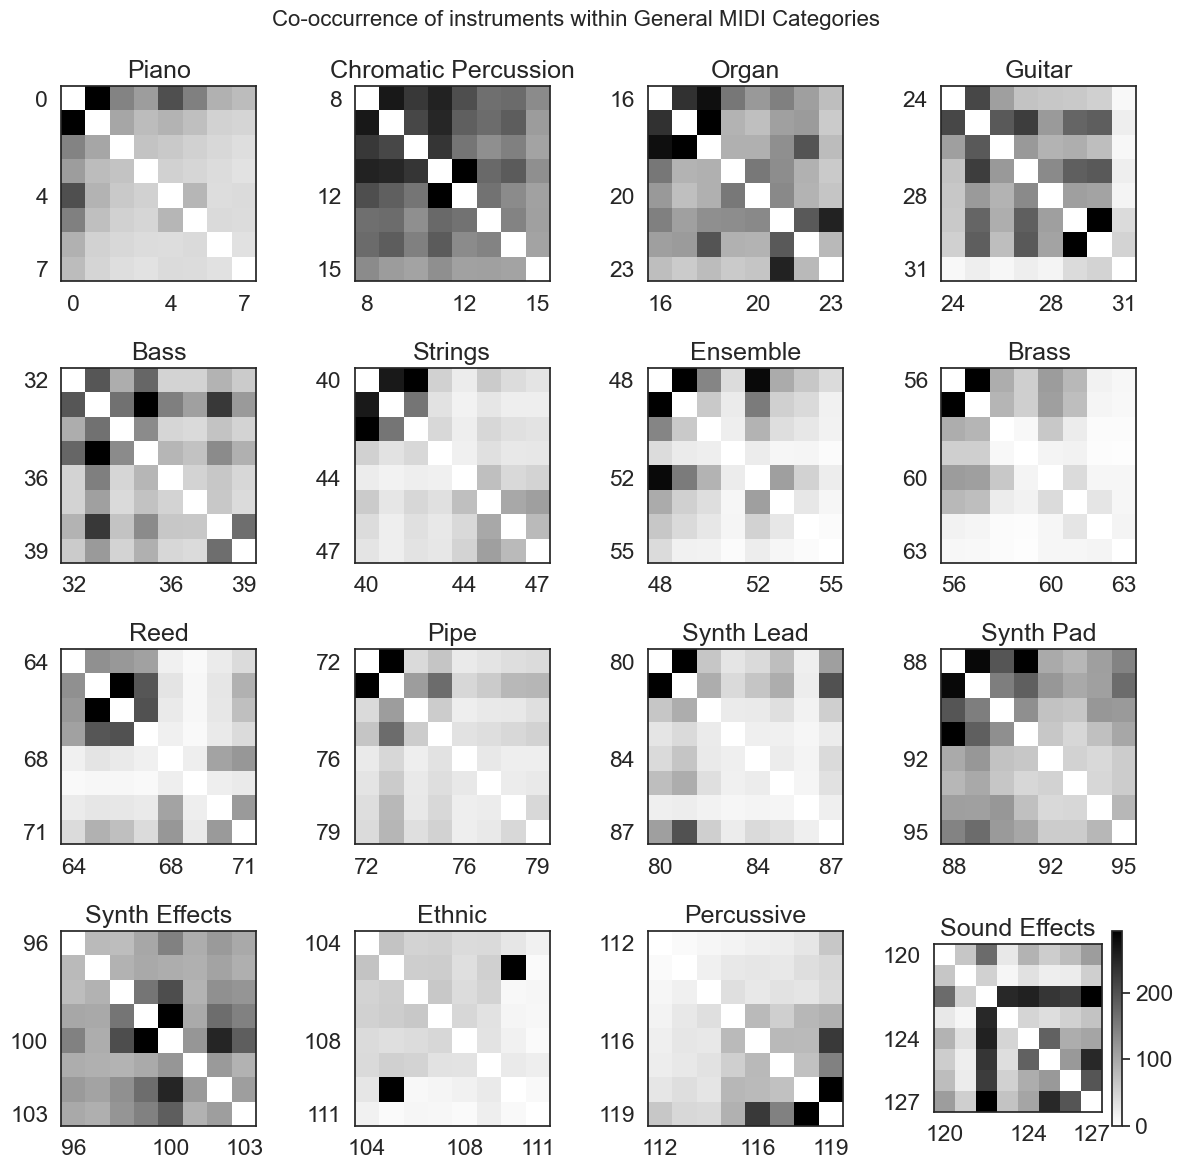

In [17]:
plt.figure(figsize=(12, 12))
plt.suptitle("Co-occurrence of instruments within General MIDI Categories", fontsize=16)

vmin = np.min(program_cooc)
vmax = np.max(program_cooc)

for i, (category, programs) in enumerate(reduced_instruments.items()):
    plt.subplot(4, 4, i + 1)
    plt.imshow(program_cooc[programs][:, programs], cmap='gray_r') #, vmin=vmin, vmax=vmax)
    plt.title(category_names[i])
    plt.yticks([0, len(programs) // 2, len(programs) - 1], [programs[0], programs[len(programs) // 2], programs[-1]])
    plt.xticks([0, len(programs) // 2, len(programs) - 1], [programs[0], programs[len(programs) // 2], programs[-1]])


plt.tight_layout()
plt.colorbar()
plt.savefig('cooc.png')

Program number: 0, Count: 0.0
Program number: 111, Count: 155.0
Program number: 113, Count: 175.0
Program number: 121, Count: 313.0
Program number: 86, Count: 321.0
Program number: 123, Count: 349.0
Program number: 106, Count: 381.0
Program number: 112, Count: 428.0
Program number: 109, Count: 449.0
Program number: 125, Count: 468.0
Program number: 97, Count: 500.0
Program number: 101, Count: 506.0
Program number: 83, Count: 525.0
Program number: 114, Count: 535.0
Program number: 107, Count: 576.0
Program number: 115, Count: 598.0
Program number: 76, Count: 635.0
Program number: 108, Count: 655.0
Program number: 104, Count: 704.0
Program number: 117, Count: 711.0
Program number: 127, Count: 754.0
Program number: 103, Count: 760.0
Program number: 126, Count: 771.0
Program number: 116, Count: 781.0
Program number: 124, Count: 823.0
Program number: 96, Count: 863.0
Program number: 92, Count: 926.0
Program number: 77, Count: 979.0
Program number: 120, Count: 1003.0
Program number: 93, Coun

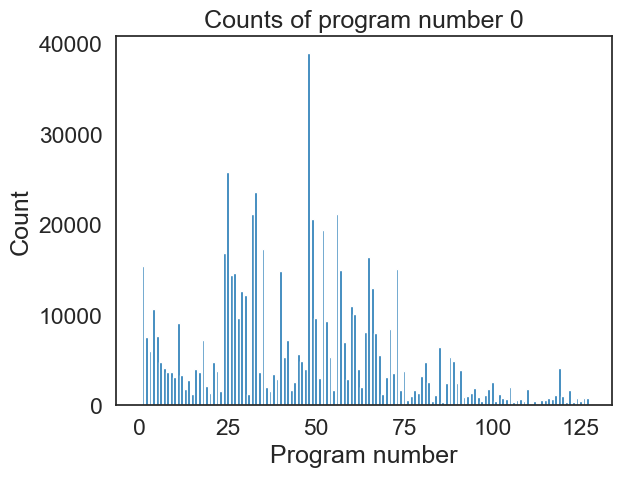

In [53]:
# Plot a row of program_cooc as a bar graph
row = 0
plt.bar(range(128), program_cooc[row])
plt.xlabel('Program number')
plt.ylabel('Count')
plt.title(f'Counts of program number {row}')
# plt.show()

sorted_programs = np.argsort(program_cooc[row])
for i in sorted_programs:
    print(f'Program number: {i}, Count: {program_cooc[row, i]}')

[1, 4, 5, 16, 17, 18, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 49, 50, 51, 52, 53, 54, 55, 62, 63, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
[0, 21, 32, 40, 41, 42, 43, 44, 45, 46, 47, 48, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 85, 91, 105, 110]
[2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 114, 19, 20, 23]


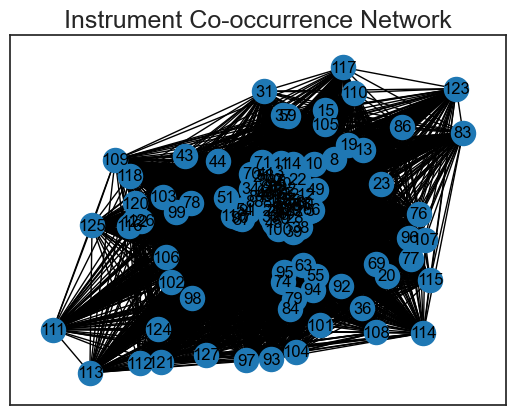

In [31]:
import networkx as nx
import numpy as np

# Create a graph from the co-occurrence matrix
G = nx.Graph()
for i in range(len(program_cooc)):
    for j in range(len(program_cooc[i])):
        # Add an edge only if there is a co-occurrence
        if program_cooc[i][j] > 0:
            G.add_edge(i, j, weight=program_cooc[i][j])

# Find communities (clusters) using the Clauset-Newman-Moore greedy modularity maximization
communities = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')

# Print the communities
for community in communities:
    print(list(community))

# Draw the network
pos = nx.spring_layout(G)  # positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# Label nodes
nx.draw_networkx_labels(G, pos)

plt.title('Instrument Co-occurrence Network')
plt.show()

/var/folders/nx/fjyfydpx6dnfh11zfj24bdph0000gn/T/ipykernel_73259/1719647598.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


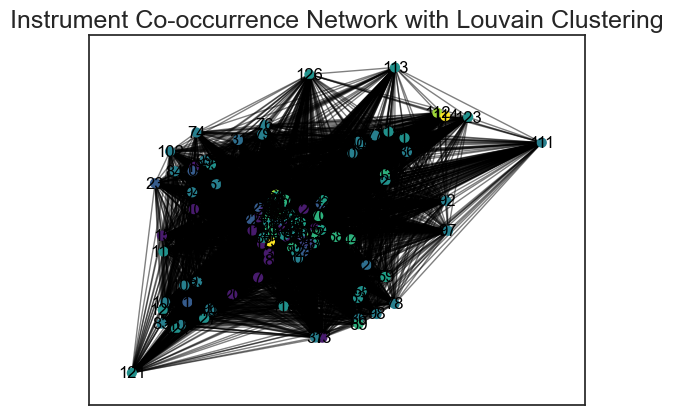

Community 0: [0]
Community 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20]
Community 2: [18, 26, 28, 35, 53]
Community 3: [88, 91]
Community 4: [21, 22, 23, 24, 32, 105, 110]
Community 5: [25, 27, 29, 30, 31, 33, 34, 120]
Community 6: [36, 37, 51, 74, 76, 77, 78, 79, 83, 84, 86, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 111]
Community 7: [38, 39, 50, 55, 62, 63, 80, 81, 82, 87, 90, 95, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127]
Community 8: [40, 41, 42, 56, 57, 58, 59, 64, 65, 66, 67, 85]
Community 9: [43, 44, 45, 46, 47, 48, 60, 68, 69, 70, 71, 72, 73]
Community 10: [49, 89]
Community 11: [52]
Community 12: [54, 112]
Community 13: [61]
Community 14: [75, 114]


In [39]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain

# Create a graph from the co-occurrence matrix
G = nx.Graph()
for i in range(len(program_cooc)):
    for j in range(i, len(program_cooc)):
        if program_cooc[i][j] > 0:
            G.add_edge(i, j, weight=program_cooc[i][j])

# Use the Louvain method for community detection
partition = community_louvain.best_partition(G, resolution=1.5)

# Visualization
pos = nx.spring_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.title('Instrument Co-occurrence Network with Louvain Clustering')
plt.show()

# # Print the community of each node
# for i, comm in partition.items():
#     print(f"Instrument {i} is in community {comm}")

# Print each community as a list
for comm in set(partition.values()):
    print(f"Community {comm}: {[i for i in partition.keys() if partition[i] == comm]}")


In [ ]:
# create groups
# sweep through statistics, count how many times there is group collision in a track
# decide what to do when there is group collision



In [21]:
# Count the occurrences of each program number
program_counts = collections.Counter(program_nums)
program_counts = sorted(program_counts.items(), key=lambda x: x[1])
program_counts


[(111, 438),
 (113, 534),
 (121, 541),
 (123, 614),
 (86, 670),
 (109, 852),
 (106, 854),
 (112, 865),
 (97, 881),
 (125, 1021),
 (101, 1028),
 (83, 1105),
 (108, 1129),
 (76, 1142),
 (124, 1195),
 (15, 1223),
 (115, 1286),
 (107, 1394),
 (114, 1427),
 (96, 1459),
 (126, 1488),
 (117, 1583),
 (103, 1586),
 (127, 1672),
 (77, 1693),
 (13, 1695),
 (104, 1722),
 (93, 1790),
 (92, 1836),
 (98, 1876),
 (116, 1965),
 (20, 1971),
 (69, 2046),
 (102, 2221),
 (118, 2248),
 (120, 2276),
 (84, 2282),
 (110, 2674),
 (94, 2698),
 (31, 2893),
 (78, 2924),
 (122, 2932),
 (37, 3001),
 (43, 3085),
 (36, 3316),
 (55, 3319),
 (74, 3373),
 (23, 3454),
 (14, 3514),
 (95, 3633),
 (99, 3669),
 (59, 3683),
 (79, 3766),
 (8, 3775),
 (10, 3822),
 (105, 3913),
 (63, 3979),
 (19, 4159),
 (9, 4380),
 (44, 4384),
 (12, 4617),
 (70, 4664),
 (100, 4708),
 (82, 5101),
 (51, 5182),
 (91, 5239),
 (41, 5241),
 (90, 5401),
 (72, 5459),
 (87, 5895),
 (85, 5898),
 (3, 6330),
 (39, 6347),
 (80, 6522),
 (22, 6566),
 (75, 6608

## Tempo changes
The timing of events in MIDI files is determined by tempo change events, which allow conversion from the MIDI "tick" timebase to absolute time in seconds.  Using many tempo change events can allow for a MIDI transcription's timing to closely match that of a specific performance of a piece of music.  While 120bpm is the default tempo for a MIDI file, the distribution of tempos shows that a wide variety of tempos is used.

/Users/npb/Desktop/lmd-statistics/plotting.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(float(t) / divisor)


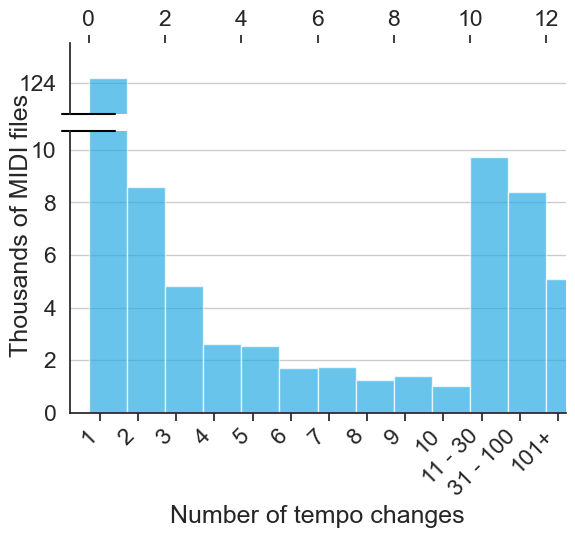

In [115]:
plotting.plot_hist([len(s['tempos']) for s in statistics], list(range(1, 12)) + [30, 100, 1000],
                   'Number of tempo changes', 'Thousands of MIDI files')
plt.xticks(np.arange(13) + .3, list(range(1, 11)) + ['11 - 30', '31 - 100', '101+'],
           rotation=45, ha='right');

/Users/npb/Desktop/lmd-statistics/plotting.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(float(t) / divisor)


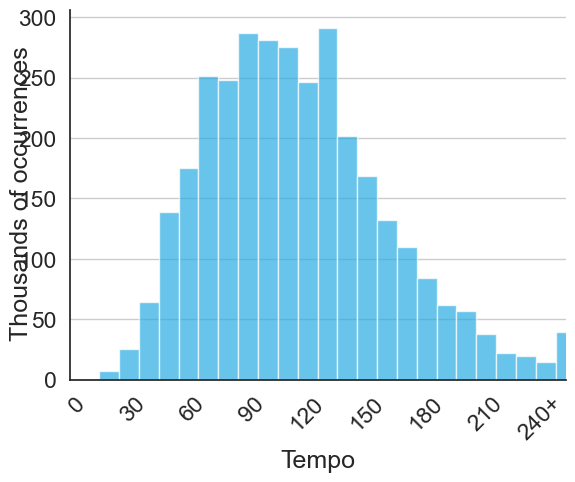

In [117]:
plotting.plot_hist([i for s in statistics for i in s['tempos']], range(0, 260, 10),
                   'Tempo', 'Thousands of occurrences')
plt.xticks(np.arange(0, len(range(0, 260, 10)), 3) + .5, list(range(0, 240, 30)) + ['240+'],
           rotation=45, ha='right');

## Time signature changes
As their name suggests, time signature changes allow the time signature of the music to be specified.  Together with tempo change events, they allow the exact metrical structure (beats and downbeats) of a piece of music to be readily extracted.  The vast majority of MIDI files have a single time signature change event, and the vast majority of time signature changes are to 4/4, but there are nevertheless many examples in our collection with unusual metrical structure.

/Users/npb/Desktop/lmd-statistics/plotting.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(float(t) / divisor)


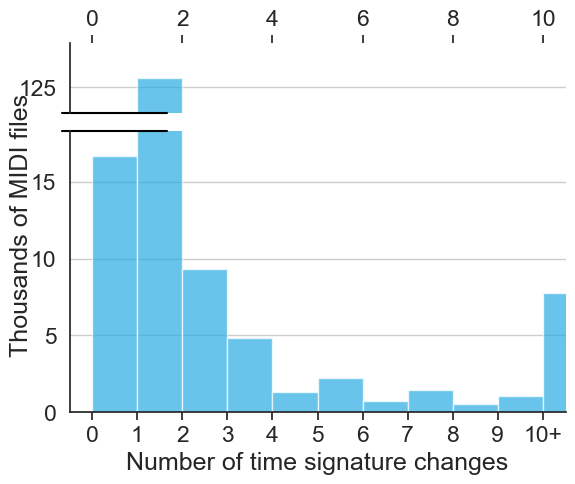

In [118]:
plotting.plot_hist([len(s['time_signature_changes']) for s in statistics], range(12),
                   'Number of time signature changes', 'Thousands of MIDI files')
plt.xticks(range(11), list(range(10)) + ['10+']);

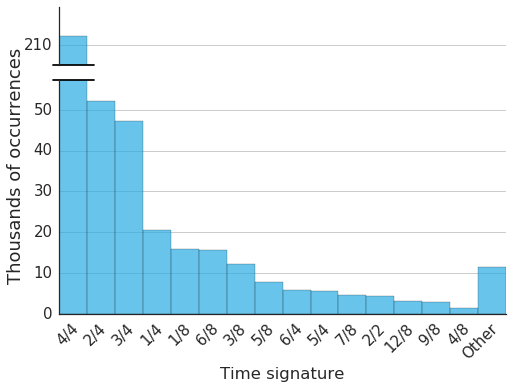

In [10]:
# Get strings for all time signatures
time_signatures = ['{}/{}'.format(c.numerator, c.denominator)
                   for s in statistics for c in s['time_signature_changes']]

# Only display the n_top top time signatures
n_top = 15
# Get the n_top top time signatures
top = collections.Counter(time_signatures).most_common(n_top)
# Create a dict mapping an integer index to the time signature string
top_signatures = {n: s[0] for n, s in enumerate(top)}
# Add an additional index for non-top signatures
top_signatures[n_top] = 'Other'
# Compute the number of non-top time signatures
n_other = len(time_signatures) - sum(s[1] for s in top)
# Create a list with each index repeated the number of times
# each time signature appears, to be passed to plt.hist
indexed_time_signatures = sum([[n]*s[1] for n, s in enumerate(top)], [])
indexed_time_signatures += [n_top]*n_other

plotting.plot_hist(indexed_time_signatures, range(n_top + 2),
                   'Time signature', 'Thousands of occurrences')
plt.xticks(np.array(top_signatures.keys()) + .3, top_signatures.values(),
           rotation=45, ha='right');

## Key changes
The current key in a piece of music can be specified with the optional key signature change meta-events.  These events do not affect playback, so many of our MIDI files omit these events altogether, though a roughly equal number had a single key change event.  Interestingly, a disproportionate number of MIDI files had a key change to C major - this is likely a reflection of the fact that many MIDI transcription software packages automatically insert a C major key change.

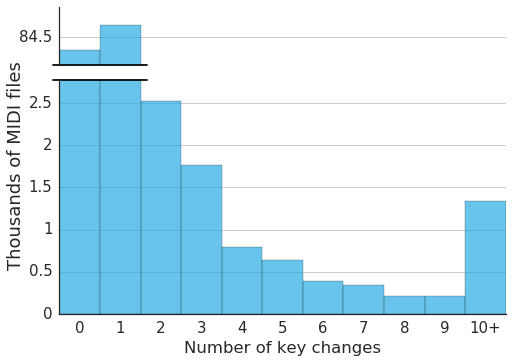

In [11]:
plotting.plot_hist([len(s['key_numbers']) for s in statistics], range(12),
                   'Number of key changes', 'Thousands of MIDI files')
plt.xticks(range(11), range(10) + ['10+']);

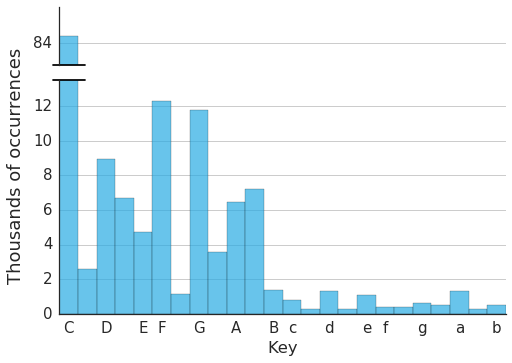

In [12]:
plotting.plot_hist([i for s in statistics for i in s['key_numbers']], range(25),
                   'Key', 'Thousands of occurrences')
plt.xticks([0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19, 21, 23],
           ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'c', 'd', 'e', 'f', 'g', 'a', 'b']);

## Lyrics
MIDI files can also optionally include timestamped lyrics events.  This in particular facilitates their use for karaoke.  In our collection, we found 23,801 MIDI files (about 13.3%) which had at least one lyrics meta-event.  Lyrics are often transcribed the word, syllable, or character level, as indicated by the distibution of the lengths of their text.  The preponderance of length-1 lyrics is also caused by characters (e.g. newlines and spaces) which indicate the end of a phrase.

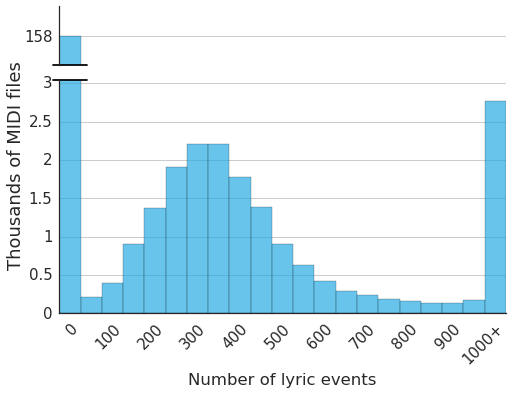

In [13]:
plotting.plot_hist([len(s['lyrics']) for s in statistics], range(0, 1060, 50),
                   'Number of lyric events', 'Thousands of MIDI files')
plt.xticks(np.arange(0, len(range(0, 1050, 50)), 2) + .5,
           range(0, 1000, 100) + ['1000+'], rotation=45, ha='right');

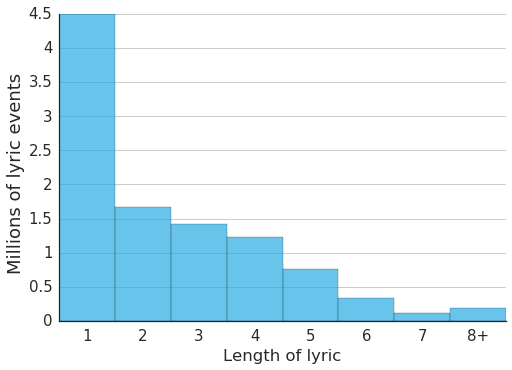

In [14]:
plotting.plot_hist([len(l) for s in statistics for l in s['lyrics']], range(1, 10),
                   'Length of lyric', 'Millions of lyric events', 1000000)
plt.xticks(range(0, 8), range(1, 8) + ['8+']);